In [4]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
import textstat
import json
from openai import OpenAI
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [7]:
with open('open_good_first_issues_with_comments.json', 'r', encoding='utf-8') as f:
    issues = json.load(f)

# Count the number of issues
issue_count = len(issues)

print(f"✅ Total number of issues: {issue_count}")

✅ Total number of issues: 28


In [36]:
# Take 28 human validated GFIs to get their charcteristics
# This is the number of labeled GFIs that were found at that moment on the Jabref GitHub issue page. These are open GFIs.

df_gfi = pd.read_csv("open_good_first_issues_with_comments.csv")

# METRIC FUNCTIONS

def get_char_length(text):
    return len(text)

def get_total_words(text):
    return len(re.findall(r'\b\w+\b', text))

def get_unique_words(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return len(set(words))

def get_hapax_score(text):
    words = re.findall(r'\b\w+\b', text.lower())
    counts = Counter(words)
    hapax = [word for word, count in counts.items() if count == 1]
    hapax_ratio = len(hapax) / len(words) if words else 0
    return len(hapax), hapax_ratio

def has_checklist(text):
    return bool(re.search(r"\[\s?[x ]\]", text, re.IGNORECASE))

def has_code_snippet(text):
    return '```' in text or bool(re.search(r'<code>|</code>', text))

def has_image(text):
    return bool(re.search(r'!$begin:math:display$.*?$end:math:display$$begin:math:text$.*?$end:math:text$', text)) or bool(re.search(r'<img.*?>', text))

def get_readability(text):
    try:
        return textstat.flesch_reading_ease(text)
    except:
        return None

# APPLY METRICS

df_gfi['char_length'] = df_gfi['description'].apply(get_char_length)
df_gfi['total_words'] = df_gfi['description'].apply(get_total_words)
df_gfi['unique_words'] = df_gfi['description'].apply(get_unique_words)
df_gfi[['hapax', 'hapax_ratio']] = df_gfi['description'].apply(lambda x: pd.Series(get_hapax_score(x)))
df_gfi['has_checklist'] = df_gfi['description'].apply(has_checklist)
df_gfi['has_code_snippet'] = df_gfi['description'].apply(has_code_snippet)
df_gfi['has_image'] = df_gfi['description'].apply(has_image)
df_gfi['readability'] = df_gfi['description'].apply(get_readability)

# STATS SUMMARY

summary = df_gfi[[
    'char_length', 'total_words', 'unique_words',
    'hapax', 'hapax_ratio', 'readability',
    'has_checklist', 'has_code_snippet', 'has_image',
    'comments_count'  # already in our data
]].describe(include='all')

print("✅ Summary of 28 Validated GFIs:\n")
print(summary)

# Validated GFIs + metrics to JSON
df_gfi.to_json("human_validated_open_gfis_with_metrics.json", orient="records", indent=2, force_ascii=False)

print("✅ Saved validated GFIs with metrics to human_validated_open_gfis_with_metrics.json")



✅ Summary of 28 Validated GFIs:

         char_length  total_words  unique_words       hapax  hapax_ratio  \
count      28.000000    28.000000     28.000000   28.000000    28.000000   
unique           NaN          NaN           NaN         NaN          NaN   
top              NaN          NaN           NaN         NaN          NaN   
freq             NaN          NaN           NaN         NaN          NaN   
mean     1525.464286   233.607143    104.821429   70.464286     0.437745   
std      2351.141779   353.017819     55.908029   32.797337     0.136598   
min       108.000000    18.000000     12.000000    8.000000     0.066905   
25%       657.000000    99.250000     71.250000   51.500000     0.358945   
50%       941.000000   144.500000     93.500000   65.000000     0.426928   
75%      1621.000000   247.250000    145.250000  100.750000     0.520639   
max     13046.000000  1958.000000    255.000000  131.000000     0.692308   

        readability has_checklist has_code_snippet has

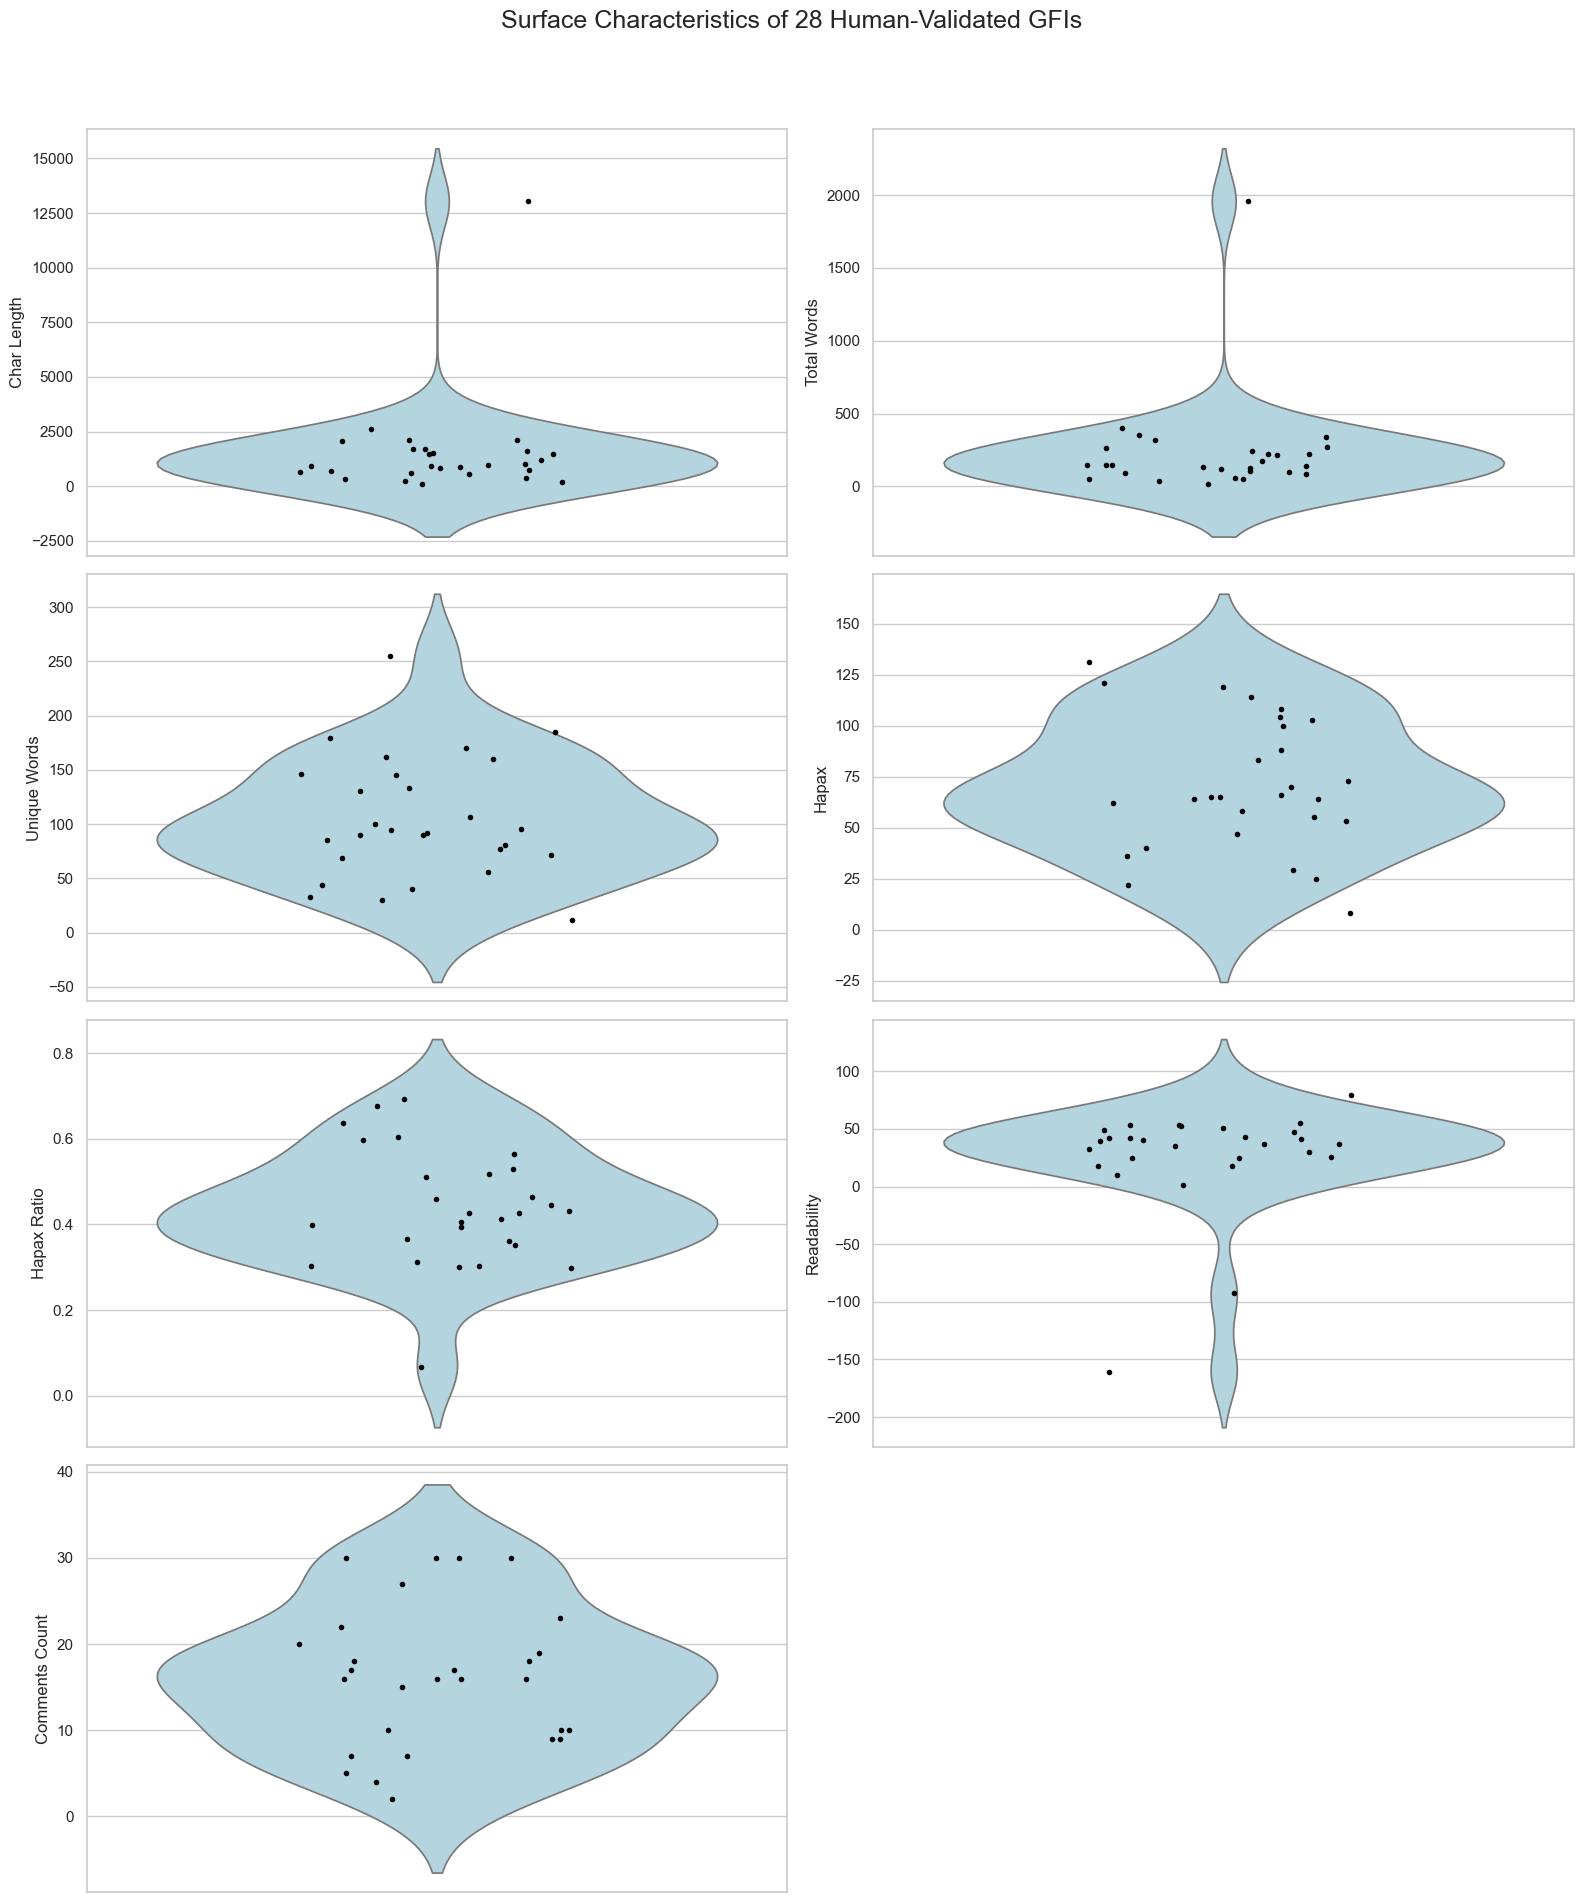

/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/2080347618.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.str.replace('_', ' ').str.title(), y=counts.values, palette="muted")


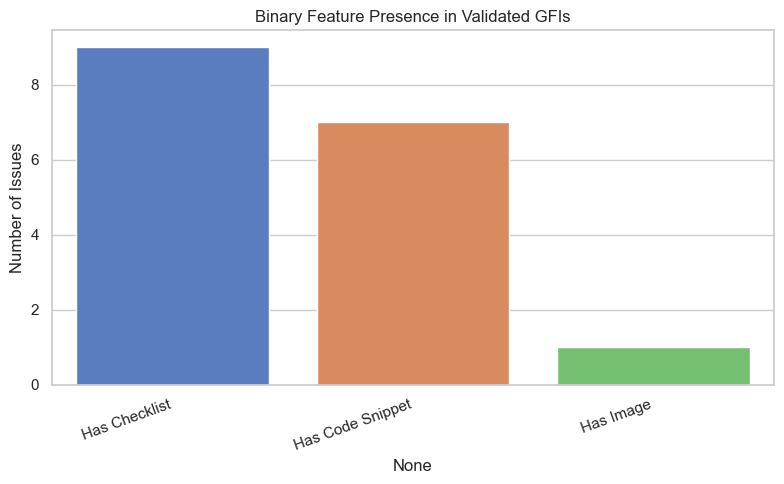

In [204]:
# Plot results with violin plots
# These are univariate violin plots. We are not comparing those metrics to anything else (the x axis does not represent anything in particular).
# The fact that some points are more on the right or on the left is just a visual effect to avoid for them to be on top of each other.

# Load data
df_gfi = pd.read_json("human_validated_open_gfis_with_metrics.json")

# Setup
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Surface Characteristics of 28 Human-Validated GFIs', fontsize=18)

# Continuous Metrics: Violin + Strip plots
continuous_metrics = [
    'char_length', 'total_words', 'unique_words', 
    'hapax', 'hapax_ratio', 'readability', 'comments_count'
]

for ax, metric in zip(axes.flatten(), continuous_metrics):
    sns.violinplot(y=df_gfi[metric], ax=ax, inner=None, color='lightblue')
    sns.stripplot(y=df_gfi[metric], ax=ax, color='black', size=4, jitter=0.2)
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_xlabel('')

# Hide any empty plots (because 7 metrics, 8 spots)
for j in range(len(continuous_metrics), len(axes.flatten())):
    axes.flatten()[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Binary Metrics: Bar Charts
binary_metrics = ['has_checklist', 'has_code_snippet', 'has_image']

plt.figure(figsize=(8,5))
counts = df_gfi[binary_metrics].sum()
sns.barplot(x=counts.index.str.replace('_', ' ').str.title(), y=counts.values, palette="muted")
plt.title('Binary Feature Presence in Validated GFIs')
plt.ylabel('Number of Issues')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

### Ask GPT API for qualitative characteristics

In [42]:
client = OpenAI(api_key = "")


# Validated GFIs from JSON
with open("human_validated_open_gfis_with_metrics.json", "r", encoding="utf-8") as f:
    validated_gfis = json.load(f)

# validated_gfis should be a list of dictionaries
print(f"✅ Loaded {len(validated_gfis)} validated GFIs.")

# GPT Analysis Function
def analyze_gfi_with_gpt(issue):
    prompt = f"""
You are a technical project maintainer.

Analyze the following GitHub issue based on these known metrics:

- Character length: {issue['char_length']}
- Total words: {issue['total_words']}
- Unique words: {issue['unique_words']}
- Hapax ratio: {issue['hapax_ratio']}
- Readability (Flesch score): {issue['readability']}
- Comments count: {issue['comments_count']}
- Checklist present: {'Yes' if issue['has_checklist'] else 'No'}
- Code snippet present: {'Yes' if issue['has_code_snippet'] else 'No'}
- Image present: {'Yes' if issue['has_image'] else 'No'}

The description is:
---
{issue['description']}
---

ONLY OUTPUT valid JSON. Do NOT include any extra text.

Format exactly:
{{
  "Small_and_Scoped": "Yes/No",
  "Clear_Steps": "Yes/No",
  "Requires_Deep_Knowledge": "Yes/No",
  "Potential_Blockers": "Yes/No + short explanation",
  "Overall_Suitability_for_Beginner": "High/Medium/Low"
}}
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o",  
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        content = response.choices[0].message.content.strip()
        return content
        
    except Exception as e:
        print(f"API Error: {e}")
        return None

gpt_outputs = []

for idx, issue in enumerate(validated_gfis):
    print(f"🔎 Processing issue {idx+1}/{len(validated_gfis)}...")
    analysis = analyze_gfi_with_gpt(issue)
    result = {
        "issue_number": issue.get('issue_number', idx),
        "title": issue.get('title', ''),
        "description": issue.get('description', ''),
        "char_length": issue.get('char_length', None),
        "total_words": issue.get('total_words', None),
        "unique_words": issue.get('unique_words', None),
        "hapax_ratio": issue.get('hapax_ratio', None),
        "readability": issue.get('readability', None),
        "comments_count": issue.get('comments_count', None),
        "has_checklist": issue.get('has_checklist', None),
        "has_code_snippet": issue.get('has_code_snippet', None),
        "has_image": issue.get('has_image', None),
        "gpt_output": analysis
    }
    gpt_outputs.append(result)
    time.sleep(1)

output_json_path = "validated_gfis_with_gpt_full_outputs.json"
with open(output_json_path, "w", encoding="utf-8") as f:
    json.dump(gpt_outputs, f, indent=2, ensure_ascii=False)

print(f"✅ Saved full GPT outputs to {output_json_path}")




✅ Loaded 28 validated GFIs.
🔎 Processing issue 1/28...
🔎 Processing issue 2/28...
🔎 Processing issue 3/28...
🔎 Processing issue 4/28...
🔎 Processing issue 5/28...
🔎 Processing issue 6/28...
🔎 Processing issue 7/28...
🔎 Processing issue 8/28...
🔎 Processing issue 9/28...
🔎 Processing issue 10/28...
🔎 Processing issue 11/28...
🔎 Processing issue 12/28...
🔎 Processing issue 13/28...
🔎 Processing issue 14/28...
🔎 Processing issue 15/28...
🔎 Processing issue 16/28...
🔎 Processing issue 17/28...
🔎 Processing issue 18/28...
🔎 Processing issue 19/28...
🔎 Processing issue 20/28...
🔎 Processing issue 21/28...
🔎 Processing issue 22/28...
🔎 Processing issue 23/28...
🔎 Processing issue 24/28...
🔎 Processing issue 25/28...
🔎 Processing issue 26/28...
🔎 Processing issue 27/28...
🔎 Processing issue 28/28...
✅ Saved full GPT outputs to validated_gfis_with_gpt_full_outputs.json


In [48]:
# Put into dataframe

with open("validated_gfis_with_gpt_full_outputs.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten into a DataFrame
flat_data = []
for item in data:
    gpt_raw = item.get('gpt_output')

    if gpt_raw is None or gpt_raw.strip() == "":
        # Empty or missing GPT output
        gpt_parsed = {}
    else:
        try:
            # Get rid of the triple backticks
            gpt_cleaned = re.sub(r"^```json\s*", "", gpt_raw.strip(), flags=re.IGNORECASE)
            gpt_cleaned = gpt_cleaned.strip("`")  # Remove trailing backticks
            gpt_cleaned = gpt_cleaned.strip()

            # Now parse as JSON
            gpt_parsed = json.loads(gpt_cleaned)

        except Exception as e:
            print(f"Failed to parse cleaned GPT output for issue {item.get('issue_number', '?')}: {e}")
            gpt_parsed = {}

    entry = {
        "issue_number": item.get("issue_number"),
        "title": item.get("title"),
        "Small_and_Scoped": gpt_parsed.get("Small_and_Scoped"),
        "Clear_Steps": gpt_parsed.get("Clear_Steps"),
        "Requires_Deep_Knowledge": gpt_parsed.get("Requires_Deep_Knowledge"),
        "Potential_Blockers": gpt_parsed.get("Potential_Blockers"),
        "Overall_Suitability_for_Beginner": gpt_parsed.get("Overall_Suitability_for_Beginner"),
    }
    flat_data.append(entry)

df_gpt = pd.DataFrame(flat_data)

print("✅ Successfully expanded GPT outputs into DataFrame!")

✅ Successfully expanded GPT outputs into DataFrame!


In [79]:
df_gpt.to_csv("GPT_validated_gfis_with_gptRating.csv")
print("✅ Successfully saved csv!")

✅ Successfully saved csv!


In [50]:
df_gpt.head(5)

,issue_number,title,Small_and_Scoped,Clear_Steps,Requires_Deep_Knowledge,Potential_Blockers,Overall_Suitability_for_Beginner
0,12928,About dialog does not show all maintainers,Yes,Yes,No,No,High
1,12921,Trying to rearrange the welcome tab causes an ...,Yes,Yes,No,No,High
2,12810,Implement escaping for keyword separators,Yes,Yes,No,No,High
3,12659,"Add ""Add JabRef suggested groups""",Yes,Yes,No,"Yes, UI implementation might require familiari...",High
4,12655,Importing settings does not work completely! (...,Yes,Yes,No,No,High


In [52]:
# Frequency counts for categorical data
print("Summary of GPT Classifications:\n")
print(df_gpt['Small_and_Scoped'].value_counts(dropna=False))
print("\n")
print(df_gpt['Clear_Steps'].value_counts(dropna=False))
print("\n")
print(df_gpt['Requires_Deep_Knowledge'].value_counts(dropna=False))
print("\n")
print(df_gpt['Overall_Suitability_for_Beginner'].value_counts(dropna=False))

Summary of GPT Classifications:

Small_and_Scoped
Yes    25
No      3
Name: count, dtype: int64


Clear_Steps
Yes    21
No      7
Name: count, dtype: int64


Requires_Deep_Knowledge
No     23
Yes     5
Name: count, dtype: int64


Overall_Suitability_for_Beginner
High      18
Low        5
Medium     5
Name: count, dtype: int64


In [54]:
# Percentage table
def print_percentages(series, title):
    print(f"=== {title} ===")
    counts = series.value_counts(dropna=False)
    percentages = counts / counts.sum() * 100
    print(pd.DataFrame({'Count': counts, 'Percentage': percentages.round(2)}))
    print("\n")

print_percentages(df_gpt['Small_and_Scoped'], "Small and Scoped")
print_percentages(df_gpt['Clear_Steps'], "Clear Steps Provided")
print_percentages(df_gpt['Requires_Deep_Knowledge'], "Requires Deep Knowledge")
print_percentages(df_gpt['Overall_Suitability_for_Beginner'], "Suitability for Beginner")

=== Small and Scoped ===
                  Count  Percentage
Small_and_Scoped                   
Yes                  25       89.29
No                    3       10.71


=== Clear Steps Provided ===
             Count  Percentage
Clear_Steps                   
Yes             21        75.0
No               7        25.0


=== Requires Deep Knowledge ===
                         Count  Percentage
Requires_Deep_Knowledge                   
No                          23       82.14
Yes                          5       17.86


=== Suitability for Beginner ===
                                  Count  Percentage
Overall_Suitability_for_Beginner                   
High                                 18       64.29
Low                                   5       17.86
Medium                                5       17.86




In [56]:
# Potential blockers: things that could make it harder for beginners
print("=== Most Common Blockers Mentioned ===")
print(df_gpt['Potential_Blockers'].value_counts().head(10))

=== Most Common Blockers Mentioned ===
Potential_Blockers
No                                                                                                                                            17
Yes, UI implementation might require familiarity with the existing codebase                                                                    1
Yes, potential merge conflicts if done in parallel with related task                                                                           1
Yes, the issue is not easily reproducible and involves understanding of Java and JavaFX                                                        1
Yes, lack of clear steps and context                                                                                                           1
Yes - The issue involves understanding of scripting and the internal workings of JabRef, which might require deep knowledge of the system.     1
Yes, understanding of file linking and database management is required  

/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/628082865.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=series, palette='Set2')


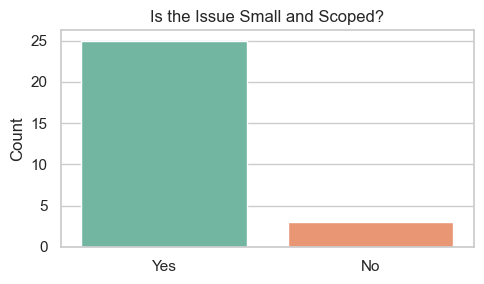

/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/628082865.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=series, palette='Set2')


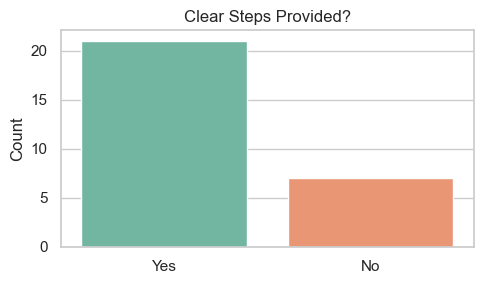

/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/628082865.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=series, palette='Set2')


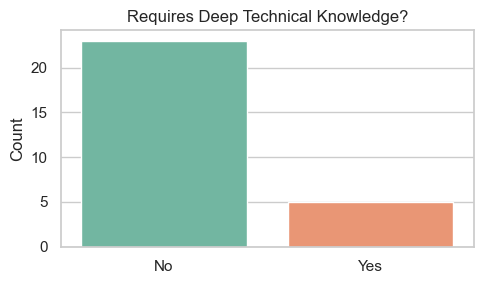

/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/628082865.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=series, palette='Set2')


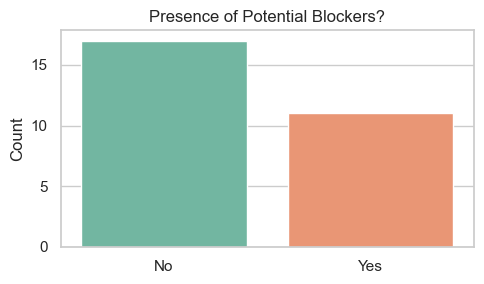

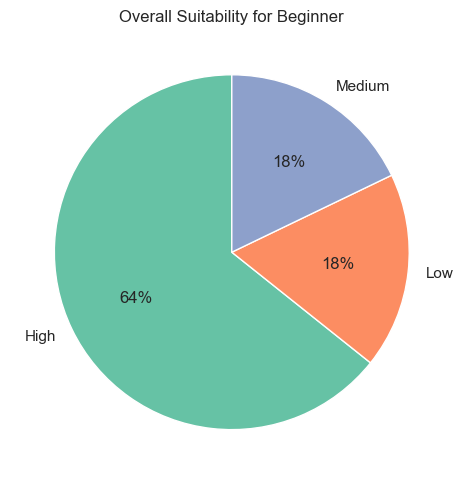

In [64]:
# Plot results

sns.set(style="whitegrid")
output_folder = "figures"
import os
os.makedirs(output_folder, exist_ok=True)

# Normalize Potential_Blockers
def normalize_blocker(response):
    if pd.isna(response):
        return "Unknown"
    if isinstance(response, str):
        if response.strip().lower().startswith("yes"):
            return "Yes"
        elif response.strip().lower() == "no":
            return "No"
    return "Unknown"

df_gpt['Blocker_Simple'] = df_gpt['Potential_Blockers'].apply(normalize_blocker)

# Plotting helper
def plot_bar(series, title, xlabel, filename):
    plt.figure(figsize=(5, 3))
    sns.countplot(x=series, palette='Set2')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"{output_folder}/{filename}")
    plt.show()

# Bar plots
plot_bar(df_gpt['Small_and_Scoped'], "Is the Issue Small and Scoped?", "", "small_and_scoped.png")
plot_bar(df_gpt['Clear_Steps'], "Clear Steps Provided?", "", "clear_steps.png")
plot_bar(df_gpt['Requires_Deep_Knowledge'], "Requires Deep Technical Knowledge?", "", "requires_deep_knowledge.png")
plot_bar(df_gpt['Blocker_Simple'], "Presence of Potential Blockers?", "", "potential_blockers.png")

# Pie chart
plt.figure(figsize=(5, 5))
df_gpt['Overall_Suitability_for_Beginner'].value_counts().plot.pie(
    autopct='%1.0f%%', startangle=90, colors=sns.color_palette('Set2')
)
plt.title('Overall Suitability for Beginner')
plt.ylabel('')
plt.tight_layout()
plt.savefig(f"{output_folder}/suitability_pie.png")
plt.show()

/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/1200846203.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x=df_gpt['Small_and_Scoped'], palette='Set2')
/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/1200846203.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 1], x=df_gpt['Clear_Steps'], palette='Set2')
/var/folders/jn/8fbnzzps7_v7r6h6n4jz5gbh0000gn/T/ipykernel_61628/1200846203.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1, 0], x=df_gpt['Requires_Dee

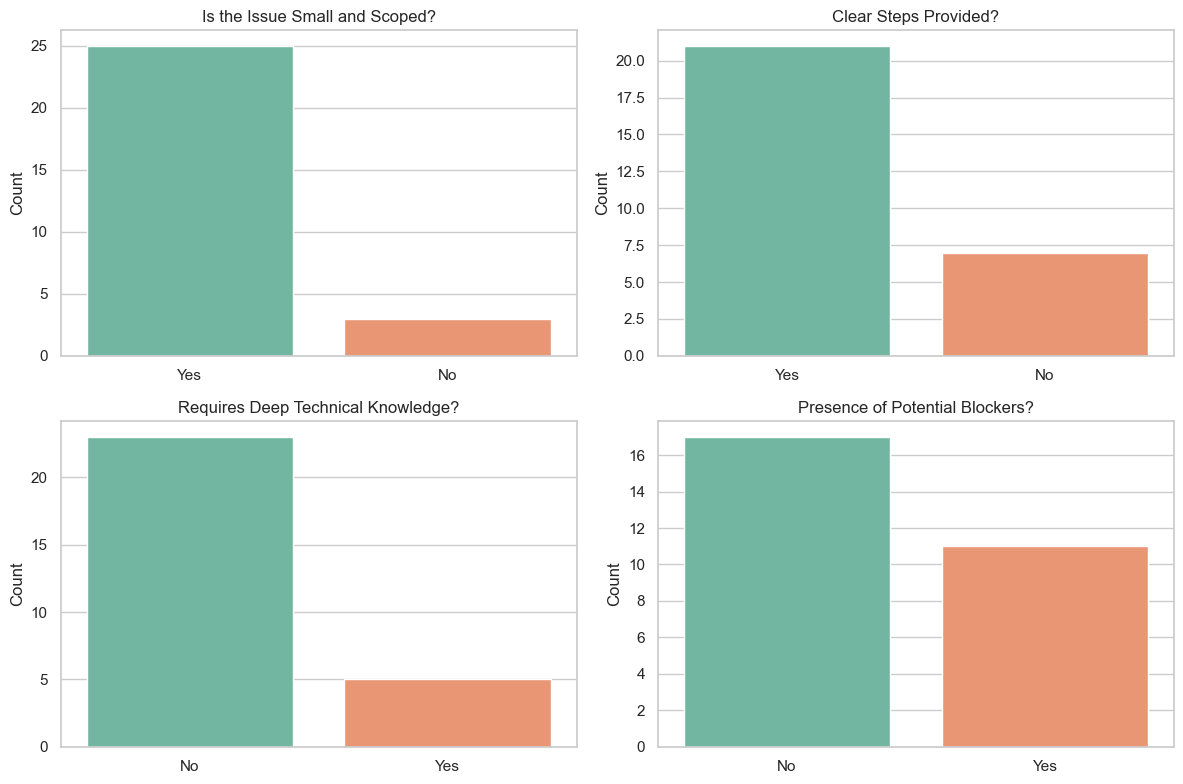

In [66]:
# Multi-panel bar plot
sns.set(style="whitegrid")
output_folder = "figures"

os.makedirs(output_folder, exist_ok=True)

# Create a Figure with Subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# First plot: Small and Scoped
sns.countplot(ax=axes[0, 0], x=df_gpt['Small_and_Scoped'], palette='Set2')
axes[0, 0].set_title("Is the Issue Small and Scoped?")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("Count")

# Second plot: Clear Steps Provided
sns.countplot(ax=axes[0, 1], x=df_gpt['Clear_Steps'], palette='Set2')
axes[0, 1].set_title("Clear Steps Provided?")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("Count")

# Third plot: Requires Deep Knowledge
sns.countplot(ax=axes[1, 0], x=df_gpt['Requires_Deep_Knowledge'], palette='Set2')
axes[1, 0].set_title("Requires Deep Technical Knowledge?")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("Count")

# Fourth plot: Potential Blockers
sns.countplot(ax=axes[1, 1], x=df_gpt['Blocker_Simple'], palette='Set2')
axes[1, 1].set_title("Presence of Potential Blockers?")
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.savefig(f"{output_folder}/combined_bar_plots.png")
plt.show()

### We need to parse the df_gpt because the gpt result cell is formatted like a JSON and did not populate in other columns.

In [85]:
# Combine the 2 csvs so that we get only one with metrics and with GPT scores
df_gpt = pd.read_csv("GPT_validated_gfis_with_gptRating.csv")  # contains expanded GPT outputs
df_metrics = pd.read_csv("validated_gfis_gpt_characteristics_analysis_expanded.csv")

df_combined = df_gpt.merge(df_metrics, on="issue_number", suffixes = ("_gpt", "_metrics"))

print(f"✅ Merged DataFrame shape: {df_combined.shape}")

print(df_combined.columns)
df_combined.to_csv("human_validated_gfis_metrics_and_gpt_scores.csv")
print(f"✅ Saved csv")


✅ Merged DataFrame shape: (28, 28)
Index(['Unnamed: 0', 'issue_number', 'title_gpt', 'Small_and_Scoped_gpt',
       'Clear_Steps_gpt', 'Requires_Deep_Knowledge_gpt',
       'Potential_Blockers_gpt', 'Overall_Suitability_for_Beginner_gpt',
       'Blocker_Simple', 'title_metrics', 'url', 'description',
       'comments_count', 'char_length', 'total_words', 'unique_words', 'hapax',
       'hapax_ratio', 'has_checklist', 'has_code_snippet', 'has_image',
       'readability', 'gpt_analysis', 'Small_and_Scoped_metrics',
       'Clear_Steps_metrics', 'Requires_Deep_Knowledge_metrics',
       'Potential_Blockers_metrics',
       'Overall_Suitability_for_Beginner_metrics'],
      dtype='object')
✅ Saved csv


I erased manually the columns not needed.

In [93]:
# Rename important columns after merge
# Reload the csv as I erased some columns manually
df_combined = pd.read_csv("human_validated_gfis_metrics_and_gpt_scores.csv")
df_combined = df_combined.rename(columns={
    'title_gpt': 'title',
    'Small_and_Scoped_gpt': 'Small_and_Scoped',
    'Clear_Steps_gpt': 'Clear_Steps',
    'Requires_Deep_Knowledge_gpt': 'Requires_Deep_Knowledge',
    'Potential_Blockers_gpt': 'Potential_Blockers',
    'Overall_Suitability_for_Beginner_gpt': 'Overall_Suitability_for_Beginner'
})
# Remove any columns with "Unnamed" in their name
df_combined = df_combined.loc[:, ~df_combined.columns.str.contains('^Unnamed')]
print("✅ Removed Unnamed columns.")
df_combined.to_csv("human_validated_gfis_metrics_and_gpt_scores_clean_column_titles.csv", index=False)
print(f"✅ Saved csv")

✅ Removed Unnamed columns.
✅ Saved csv


Now before using those metrics in GPT API in the prompt, we want to compute a combined surface metric score and then a combined GPT score.

In [96]:
# Compute surface score between 0 and 1,
# where higher = more likely to be beginner-friendly based on surface features

df = pd.read_csv("human_validated_gfis_metrics_and_gpt_scores_clean_column_titles.csv")

surface_metrics = [
    'readability',     # higher is better
    'char_length',     # lower is better
    'comments_count',  # lower is better
    'hapax_ratio'      # higher is better
]

metrics_df = df[surface_metrics].copy()

# Invert metrics where lower is better
metrics_df['char_length'] = -metrics_df['char_length']
metrics_df['comments_count'] = -metrics_df['comments_count']

# Normalize all metrics between 0 and 1
scaler = MinMaxScaler()
metrics_normalized = scaler.fit_transform(metrics_df)

# Create Surface Metric Score by averaging the normalized values
df['surface_metric_score'] = metrics_normalized.mean(axis=1)

print("✅ Surface Metric Score computed successfully!")

df.to_csv("issues_combined_with_surface_score.csv", index=False)
print("✅ Saved file with surface_metric_score added!")

✅ Surface Metric Score computed successfully!
✅ Saved file with surface_metric_score added!


In [98]:
# Compute GPT combined qualitative score 

df = pd.read_csv("issues_combined_with_surface_score.csv")

# Score the GPT qualitative fields
def compute_gpt_score(row):
    score = 0
    total_questions = 4  # We are using 4 yes/no style fields

    # Check each GPT field
    if row['Small_and_Scoped'] == 'Yes':
        score += 1
    if row['Clear_Steps'] == 'Yes':
        score += 1
    if row['Requires_Deep_Knowledge'] == 'No':
        score += 1
    if isinstance(row['Potential_Blockers'], str) and row['Potential_Blockers'].strip().lower().startswith('no'):
        score += 1

    # Normalize: divide by the total number of questions
    normalized_score = score / total_questions
    return normalized_score

# Compute GPT Qualitative Score
df['gpt_qualitative_score'] = df.apply(compute_gpt_score, axis=1)

print("✅ GPT Qualitative Score computed successfully!")

df.to_csv("human_validated_gfis_combined_surface_and_gpt_score.csv", index=False)
print("✅ Saved file with gpt_qualitative_score added!")

✅ GPT Qualitative Score computed successfully!
✅ Saved file with gpt_qualitative_score added!


<span style="color:red"><b>Added human score of 1=GFI in csv manually</b></span>

Run a grid search to find the best combination of surface + GPT weights

✅ Best Weights Found:
Surface Metric Weight: 0.8
GPT Qualitative Weight: 0.19999999999999996
Best F1 Score: 0.982


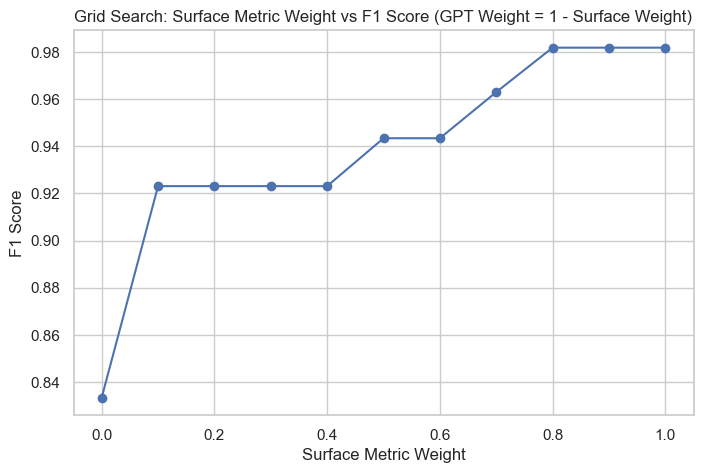

In [115]:

df = pd.read_csv("human_validated_gfis_combined_surface_and_gpt_score.csv")

# Grid Search Function
def run_weight_grid_search(df, threshold=0.5, metric='f1'):
    best_score = -1
    best_weights = (None, None)
    results = []

    for w_surface in np.arange(0.0, 1.1, 0.1):  # weights from 0.0 to 1.0
        w_gpt = 1.0 - w_surface

        # Combined Score
        df['combined_score'] = (w_surface * df['surface_metric_score']) + (w_gpt * df['gpt_qualitative_score'])

        # Predict: if combined score > threshold, predict GFI
        df['predicted_label'] = df['combined_score'] > threshold

        # Evaluate
        if metric == 'f1':
            score = f1_score(df['human_score'], df['predicted_label'])
        elif metric == 'accuracy':
            score = accuracy_score(df['human_score'], df['predicted_label'])
        elif metric == 'kappa':
            score = cohen_kappa_score(df['human_score'], df['predicted_label'])
        else:
            raise ValueError("Metric must be 'f1', 'accuracy', or 'kappa'")

        # Save results
        results.append({
            "surface_weight": w_surface,
            "gpt_weight": w_gpt,
            "score": score
        })

        # Update best
        if score > best_score:
            best_score = score
            best_weights = (w_surface, w_gpt)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return best_weights, best_score, results_df

# Run the grid search to find the weights
best_weights, best_score, results_df = run_weight_grid_search(df, threshold=0.5, metric='f1')

# Best Weights and Score
print(f"✅ Best Weights Found:")
print(f"Surface Metric Weight: {best_weights[0]}")
print(f"GPT Qualitative Weight: {best_weights[1]}")
print(f"Best F1 Score: {best_score:.3f}")

plt.figure(figsize=(8,5))
plt.plot(results_df['surface_weight'], results_df['score'], marker='o')
plt.xlabel('Surface Metric Weight')
plt.ylabel('F1 Score')
plt.title('Grid Search: Surface Metric Weight vs F1 Score (GPT Weight = 1 - Surface Weight)')
plt.show()

In [119]:
# Compute general GFI score

df = pd.read_csv("human_validated_gfis_combined_surface_and_gpt_score.csv")

# Apply the best found weights
SURFACE_WEIGHT = 0.8
GPT_WEIGHT = 0.2

# Compute final GFI score
df['GFI_Score'] = (SURFACE_WEIGHT * df['surface_metric_score']) + (GPT_WEIGHT * df['gpt_qualitative_score'])

# Sort descending by GFI_Score
df_sorted = df.sort_values(by='GFI_Score', ascending=False)

df_sorted.to_csv("human_validated_gfis_ranked_by_general_gfi_score.csv", index=False)

print("✅ Computed and saved final GFI_Score for all issues!")

✅ Computed and saved final GFI_Score for all issues!


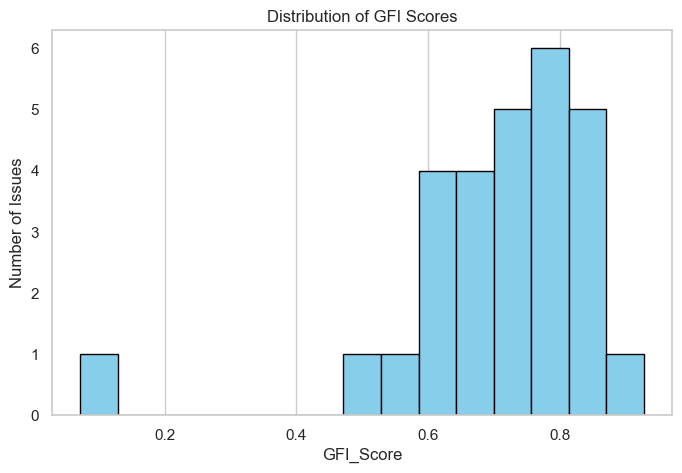

In [121]:
plt.figure(figsize=(8,5))
plt.hist(df['GFI_Score'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel('GFI_Score')
plt.ylabel('Number of Issues')
plt.title('Distribution of GFI Scores')
plt.grid(axis='y')
plt.show()

Cumulative threshold plot. Will show for each possible GFI score threshold how many issues would be classified as GFIs.

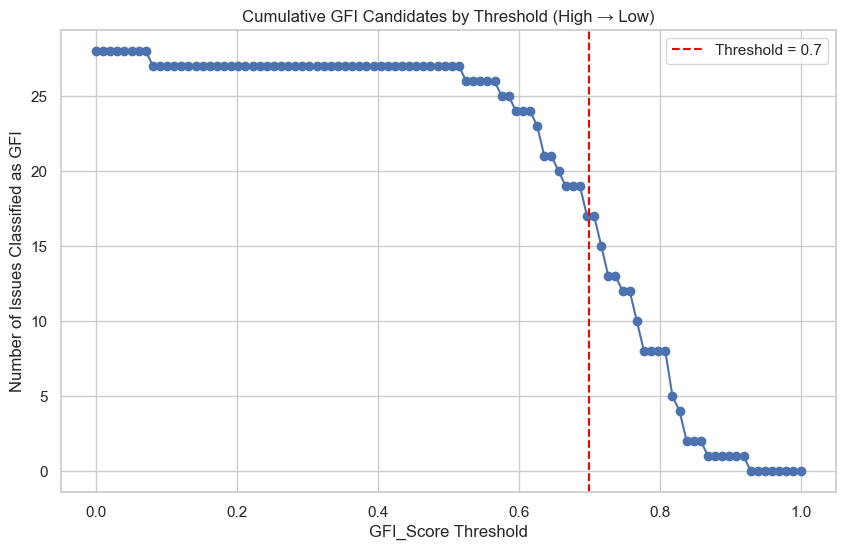

In [130]:
# Cumulative threshold plot

df = pd.read_csv("human_validated_gfis_ranked_by_general_gfi_score.csv")

# GFI Scores descending (high to low)
df_sorted = df.sort_values(by='GFI_Score', ascending=False).reset_index(drop=True)

# Compute the cumulative number of issues kept at each threshold
thresholds = np.linspace(1, 0, 100)  # Starting from 1.0 and going down to 0.0
cumulative_counts = []

for t in thresholds:
    count = (df_sorted['GFI_Score'] >= t).sum()
    cumulative_counts.append(count)

# Cumulative issues vs threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, cumulative_counts, marker='o', linestyle='-')
plt.xlabel('GFI_Score Threshold')
plt.ylabel('Number of Issues Classified as GFI')
plt.title('Cumulative GFI Candidates by Threshold (High → Low)')
plt.grid(True)

# Dashed vertical line at threshold 0.7
THRESHOLD_TO_HIGHLIGHT = 0.7

plt.axvline(x=THRESHOLD_TO_HIGHLIGHT, color='red', linestyle='--', label=f'Threshold = {THRESHOLD_TO_HIGHLIGHT}')
plt.legend()

plt.show()

### We want to inject 20 closed human-validated GFIs into our dataset to be able to verify later that GPT was able to recognize them

In [146]:
# Loading both datasets
df_main = pd.read_csv("issues_readability_lexical_commentsNbr2.csv")   # original unlabeled/main issues
df_validated = pd.read_csv("closed_good_first_issues_with_comments.csv")    # closed human-validated GFIs

# Number of GFIs to inject:
n_inject = 15

# Sample randomly from the closed validated GFIs
df_injected = df_validated.sample(n=n_inject, random_state=42).copy()

# Adding marker column
df_main['is_planted_gfi'] = False
df_injected['is_planted_gfi'] = True

# Combining the datasets
df_combined = pd.concat([df_main, df_injected], ignore_index=True)

# Shuffle the rows randomly to avoid having all the GFIs close together
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

df_combined.to_csv("issues_to_classify_with_planted_hv_closed_gfis.csv", index=False)

print(f"✅ Injected {n_inject} validated GFIs into main dataset. Ready for GPT classification!")

✅ Injected 15 validated GFIs into main dataset. Ready for GPT classification!


Use that dataset with injected human-validated closed GFIs (and other issues the status of which we do not know) and have GPT detect the GFIs.

In [137]:
# Use the GFI scored dataset and take 5 highest ranked GFIs for the prompt

df = pd.read_csv("human_validated_gfis_ranked_by_general_gfi_score.csv")

# Pick top issues by GFI Score
top_fewshot = df[df['GFI_Score'] >= 0.8].sample(n=5, random_state=42)

# Build the few-shot examples block for GPT
few_shot_examples = ""

for idx, row in top_fewshot.iterrows():
    title = row['title']
    description = row.get('description', '')
    few_shot_examples += f"Title: {title}\nBody: {description}\nGood First Issue: Yes\n\n"

print("✅ Few-shot examples prepared!")
print(few_shot_examples[:1000]) 

✅ Few-shot examples prepared!
Title: Trying to rearrange the welcome tab causes an exception
Body: ### JabRef version

Latest development branch build (please note build date below)

### Operating system

Windows

### Details on version and operating system

Build date: 2025-04-11

### Checked with the latest development build (copy version output from About dialog)

- [x] I made a backup of my libraries before testing the latest development version.
- [x] I have tested the latest development version and the problem persists

### Steps to reproduce the behaviour

1. Disable the setting to "Hide Tab bar when single library is present"
2. Create a library (Or create 2 if you skipped step 1)
3. Click and drag the Welcome tab and move it beside the newly created library
5. Error occurs

![image](https://github.com/user-attachments/assets/45a2ad59-026a-4de4-9145-1bb03fe6bd79)

### Appendix

...
<details>

<summary>Log File</summary>

```
Paste an excerpt of your log file here
```

</details

In [148]:
# Classify with GPT

client = OpenAI(api_key = "") # You can get an API Key on OpenAI and add it here

# Load the combined issues
df_classify = pd.read_csv("issues_to_classify_with_planted_hv_closed_gfis.csv")

# Add new column for GPT's prediction
df_classify['gpt_prediction'] = None

# Classification function
def classify_issue(title, description):
    prompt = few_shot_examples + f"\nTitle: {title}\nBody: {description}\nGood First Issue? Answer 'Yes' or 'No' and explain your reasoning."
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an open-source maintainer helping triage GitHub issues."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
        )
        answer = response.choices[0].message.content.strip()
        return answer
    except Exception as e:
        print(f"Error: {e}")
        return None

# Run classification
for i, row in df_classify.iterrows():
    result = classify_issue(row['title'], row['description'])
    df_classify.at[i, 'gpt_prediction'] = result
    print(f"✅ Classified {i+1}/{len(df_classify)} issues")

# Save GPT predictions
df_classify.to_csv("issues_with_planted_hv_gfis_gpt_predictions.csv", index=False)
print("✅ GPT predictions saved!")


✅ Classified 1/560 issues
✅ Classified 2/560 issues
✅ Classified 3/560 issues
✅ Classified 4/560 issues
✅ Classified 5/560 issues
✅ Classified 6/560 issues
✅ Classified 7/560 issues
✅ Classified 8/560 issues
✅ Classified 9/560 issues
✅ Classified 10/560 issues
✅ Classified 11/560 issues
✅ Classified 12/560 issues
✅ Classified 13/560 issues
✅ Classified 14/560 issues
✅ Classified 15/560 issues
✅ Classified 16/560 issues
✅ Classified 17/560 issues
✅ Classified 18/560 issues
✅ Classified 19/560 issues
✅ Classified 20/560 issues
✅ Classified 21/560 issues
✅ Classified 22/560 issues
✅ Classified 23/560 issues
✅ Classified 24/560 issues
✅ Classified 25/560 issues
✅ Classified 26/560 issues
✅ Classified 27/560 issues
✅ Classified 28/560 issues
✅ Classified 29/560 issues
✅ Classified 30/560 issues
✅ Classified 31/560 issues
✅ Classified 32/560 issues
✅ Classified 33/560 issues
✅ Classified 34/560 issues
✅ Classified 35/560 issues
✅ Classified 36/560 issues
✅ Classified 37/560 issues
✅ Classifi

In [150]:
# Evaluate how GPT recognized the planted GFIs

# Load classified dataset
df_results = pd.read_csv("issues_with_planted_hv_gfis_gpt_predictions.csv")

# Extract GPT Yes/No labels
df_results['gpt_predicted_gfi'] = df_results['gpt_prediction'].str.lower().str.startswith('yes')

# Evaluate only on planted GFIs
df_planted = df_results[df_results['is_planted_gfi'] == True]

# Calculate recall (how many planted GFIs were recognized by GPT)
recognized = (df_planted['gpt_predicted_gfi'] == True).sum()
total_planted = len(df_planted)

recall = recognized / total_planted if total_planted > 0 else 0

print(f"✅ GPT correctly recognized {recognized}/{total_planted} planted GFIs.")
print(f"Recall on planted GFIs: {recall:.2%}")


✅ GPT correctly recognized 10/15 planted GFIs.
Recall on planted GFIs: 66.67%


### Improve the recall by adding NO GFIs

In [152]:
# Mark the issues seen as second good issue, third good issue, fourth good issue on Jabref's issue page

# Load the full dataset containing the planted GFIs
df = pd.read_csv("issues_to_classify_with_planted_hv_closed_gfis.csv") 

# Manually collected issue numbers
good_second_issues = [12571, 12377, 12356]
good_third_issues = [12664, 12460, 12356]
good_fourth_issues = [12700, 12190, 11875]

# Initialize the column with empty/None
df['original_issue_label'] = None

# Assign labels based on issue number
df.loc[df['issue_number'].isin(good_second_issues), 'original_issue_label'] = 'Good Second Issue'
df.loc[df['issue_number'].isin(good_third_issues), 'original_issue_label'] = 'Good Third Issue'
df.loc[df['issue_number'].isin(good_fourth_issues), 'original_issue_label'] = 'Good Fourth Issue'

df.to_csv("issues_to_classify_with_planted_hv_closed_gfis_and_2-3-4labels.csv", index=False)

print("✅ Metadata column 'original_issue_label' added and saved!")

✅ Metadata column 'original_issue_label' added and saved!


In [162]:
# Few-shot prompt with 5 yes and 5 no
df_full = pd.read_csv("issues_to_classify_with_planted_hv_closed_gfis_and_2-3-4labels.csv")
df_gfis = pd.read_csv("human_validated_gfis_ranked_by_general_gfi_score.csv")

# 5 high-scoring GFI examples ("Yes" examples)
df_yes_examples = df_gfis[df_gfis['GFI_Score'] >= 0.8].sort_values(by='GFI_Score', ascending=False).head(5)

# 5 Good Second/Third/Fourth Issues ("No" examples)
df_no_examples = df_full[df_full['original_issue_label'].notnull()].sample(n=5, random_state=42)

system_prompt = """
You are an open-source maintainer triaging GitHub issues.

You know that Good First Issues (GFIs) have these characteristics:
- Small, well-scoped tasks
- Clear steps for reproduction or fixing
- Do not require deep system knowledge
- Involve only a single or localized part of the code

Issues that are NOT Good First Issues often:
- Require traversing multiple components
- Involve architectural or structural changes
- Are complex, unclear, or large in scope
- Involve at least a tour of 2 or 3 intertweaned components in the project

Given the Title and Body of an issue, decide if it is a Good First Issue.
Answer "Yes" or "No" and briefly explain your reasoning.
"""
few_shot_examples = ""

# YES examples
for idx, row in df_yes_examples.iterrows():
    title = str(row.get('title', '')).strip()
    description = str(row.get('description', '') or '').strip()
    few_shot_examples += f"Title: {title}\nBody: {description}\nGood First Issue: Yes\n\n"

# NO examples
for idx, row in df_no_examples.iterrows():
    title = str(row.get('title', '')).strip()
    description = str(row.get('description', '') or '').strip()
    few_shot_examples += f"Title: {title}\nBody: {description}\nGood First Issue: No\n\n"

print("✅ Few-shot block built!")

✅ Few-shot block built!


In [164]:
# GPT Classification

client = OpenAI(api_key = "")

# Dataset to classify that also contains 2-3-4 labels
df_classify = pd.read_csv("issues_to_classify_with_planted_hv_closed_gfis_and_2-3-4labels.csv")  

# Add column for GPT predictions
df_classify['gpt_prediction'] = None

# Classification function
def classify_issue(title, description):
    full_prompt = system_prompt + "\n\n" + few_shot_examples + f"Title: {title}\nBody: {description}\nGood First Issue?"

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an open-source maintainer."},
                {"role": "user", "content": full_prompt}
            ],
            temperature=0,
        )
        answer = response.choices[0].message.content.strip()
        return answer
    except Exception as e:
        print(f"Error: {e}")
        return None

# Run batch classification
for i, row in df_classify.iterrows():
    result = classify_issue(row['title'], row['description'])
    df_classify.at[i, 'gpt_prediction'] = result
    print(f"✅ Classified {i+1}/{len(df_classify)} issues")
    time.sleep(1)  # Optional: respect OpenAI API rate limits

df_classify.to_csv("issues_with_planted_hv_gfis_and_NOgfis_gpt_predictions_final.csv", index=False)

print("✅ GPT classification done and saved!")


✅ Classified 1/560 issues
✅ Classified 2/560 issues
✅ Classified 3/560 issues
✅ Classified 4/560 issues
✅ Classified 5/560 issues
✅ Classified 6/560 issues
✅ Classified 7/560 issues
✅ Classified 8/560 issues
✅ Classified 9/560 issues
✅ Classified 10/560 issues
✅ Classified 11/560 issues
✅ Classified 12/560 issues
✅ Classified 13/560 issues
✅ Classified 14/560 issues
✅ Classified 15/560 issues
✅ Classified 16/560 issues
✅ Classified 17/560 issues
✅ Classified 18/560 issues
✅ Classified 19/560 issues
✅ Classified 20/560 issues
✅ Classified 21/560 issues
✅ Classified 22/560 issues
✅ Classified 23/560 issues
✅ Classified 24/560 issues
✅ Classified 25/560 issues
✅ Classified 26/560 issues
✅ Classified 27/560 issues
✅ Classified 28/560 issues
✅ Classified 29/560 issues
✅ Classified 30/560 issues
✅ Classified 31/560 issues
✅ Classified 32/560 issues
✅ Classified 33/560 issues
✅ Classified 34/560 issues
✅ Classified 35/560 issues
✅ Classified 36/560 issues
✅ Classified 37/560 issues
✅ Classifi

In [166]:
# Evaluation: how did GPT classify planted GFis + non-Gfis
# At this stage, we only evaluated GPT’s classification on the injected GFIs and injected non-GFIs.
# We did not evaluate GPT on the entire dataset of unlabeled issues.

# Load classified dataset
df_results = pd.read_csv("issues_with_planted_hv_gfis_and_NOgfis_gpt_predictions_final.csv")

# Extract simple Yes/No from GPT output
df_results['gpt_predicted_gfi'] = df_results['gpt_prediction'].str.lower().str.startswith('yes')

# Evaluate planted GFIs
if 'is_planted_gfi' in df_results.columns:
    df_planted = df_results[df_results['is_planted_gfi'] == True]
    recognized = (df_planted['gpt_predicted_gfi'] == True).sum()
    total_planted = len(df_planted)
    recall = recognized / total_planted if total_planted > 0 else 0
    print(f"✅ Planted GFIs recognized: {recognized}/{total_planted} ({recall:.2%})")

# Evaluate Good Second/Third/Fourth behavior (False Positives)
df_no = df_results[df_results['original_issue_label'].notnull()]
wrongly_predicted_as_gfi = (df_no['gpt_predicted_gfi'] == True).sum()
total_no_examples = len(df_no)

false_positive_rate = wrongly_predicted_as_gfi / total_no_examples if total_no_examples > 0 else 0
print(f"False Positive Rate on Good Second/Third/Fourth Issues: {false_positive_rate:.2%}")


✅ Planted GFIs recognized: 6/15 (40.00%)
False Positive Rate on Good Second/Third/Fourth Issues: 0.00%


#### 3rd attempt to classify with GPT. Tweaking prompt making GPT accept more GFIs and using chain of thought
##### also using 7 YEs examples and 5 NO

In [172]:

try:
    # If a partial file exists, resume from it
    df_full = pd.read_csv("issues_classified_cot_partial.csv")
    print("Resuming from partial saved file...")
except FileNotFoundError:
    # If no partial file, start from fresh
    df_full = pd.read_csv("issues_to_classify_with_planted_hv_closed_gfis_and_2-3-4labels.csv")
    print("Starting fresh classification...")

# df_full = pd.read_csv("issues_to_classify_with_planted_hv_closed_gfis_and_2-3-4labels.csv")
df_gfis = pd.read_csv("human_validated_gfis_ranked_by_general_gfi_score.csv")


# Updated system prompt (Chain-of-Thought style)
system_prompt = """
You are an open-source maintainer triaging GitHub issues.

Good First Issues (GFIs) typically:
- Are small, well-scoped tasks
- Have clear steps for reproduction or fixing
- Do not require deep system knowledge
- Involve only a single or localized part of the code

Issues that are NOT Good First Issues often:
- Require traversing multiple components
- Involve architectural or structural changes
- Are complex, unclear, or large in scope
- Involve a tour across multiple intertwined components

When deciding if an issue is a Good First Issue, follow these steps:

1. Is the issue small and focused on a specific part of the project? (Yes/No and Why)
2. Are the steps to fix or reproduce the issue clear? (Yes/No and Why)
3. Does solving the issue require deep internal knowledge of the system? (Yes/No and Why)
4. Would a beginner reasonably be able to complete it with minimal help? (Yes/No and Why)

If most answers are "Yes" (except deep knowledge = "No"), then prefer to classify it as a Good First Issue.
If unsure, lean toward acceptance if the issue seems manageable for a motivated beginner.

Finally, provide your classification:
- Good First Issue: Yes or No
- Then briefly explain your final decision.
"""

# 7 high-quality GFIs ("Yes" examples)
df_yes_examples = df_gfis[df_gfis['GFI_Score'] >= 0.8].sort_values(by='GFI_Score', ascending=False).head(7)

# 5 manually labeled Good Second/Third/Fourth issues ("No" examples)
df_no_examples = df_full[df_full['original_issue_label'].notnull()].sample(n=5, random_state=42)

few_shot_examples = ""

# 7 YES examples (chain-of-thought style)
for idx, row in df_yes_examples.iterrows():
    title = str(row.get('title', '')).strip()
    description = str(row.get('description', '') or '').strip()
    few_shot_examples += f"""Title: {title}
Body: {description}

Reasoning:
- Small and focused? Yes (small and localized task)
- Clear steps? Yes (clearly described what needs to be done)
- Requires deep knowledge? No (basic understanding sufficient)
- Beginner can complete it? Yes (straightforward)

Good First Issue: Yes

"""

# 5 NO examples (chain-of-thought style)
for idx, row in df_no_examples.iterrows():
    title = str(row.get('title', '')).strip()
    description = str(row.get('description', '') or '').strip()
    few_shot_examples += f"""Title: {title}
Body: {description}

Reasoning:
- Small and focused? No (affects multiple areas/components)
- Clear steps? No (requires interpretation and judgment)
- Requires deep knowledge? Yes (needs architectural understanding)
- Beginner can complete it? No (high risk and technical depth)

Good First Issue: No

"""

print("Few-shot block with Chain-of-Thought built successfully!")

# Setup the GPT client
client = OpenAI(api_key = "")

# Prepare DataFrame
if 'gpt_prediction' not in df_full.columns:
    df_full['gpt_prediction'] = None

# GPT Classification Function
def classify_issue(title, description):
    full_prompt = system_prompt + "\n\n" + few_shot_examples + f"Title: {title}\nBody: {description}\n\nReasoning:"
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an open-source maintainer carefully triaging GitHub issues based on small, clear, manageable tasks."},
                {"role": "user", "content": full_prompt}
            ],
            temperature=0.2,  # Lower temperature = more consistent
            top_p=1.0,
            frequency_penalty=0,
            presence_penalty=0,
        )
        answer = response.choices[0].message.content.strip()
        return answer
    except Exception as e:
        print(f"Error: {e}")
        return None

# Batch Classification (this can take a long time)
for i, row in df_full.iterrows():
    title = str(row.get('title', '')).strip()
    description = str(row.get('description', '') or '').strip()
    result = classify_issue(title, description)
    df_full.at[i, 'gpt_prediction'] = result
    print(f"Classified {i+1}/{len(df_full)} issues")
    
    # Auto-save every 20 issues in case the computer goes to sleep
    if (i + 1) % 20 == 0:
        df_full.to_csv("issues_classified_cot_partial.csv", index=False)
        print(f"Auto-saved after {i+1} issues.")

    time.sleep(1)  # Delay for API rate limits

# Save after the full run
df_full.to_csv("issues_with_planted_hv_gfis_and_NOgfis_COT_gpt_predictions_final.csv", index=False)
print("Full GPT classification complete and saved!")

# Basic Evaluation
df_full['gpt_predicted_gfi'] = df_full['gpt_prediction'].str.lower().str.contains("good first issue: yes")

if 'is_planted_gfi' in df_full.columns:
    df_planted = df_full[df_full['is_planted_gfi'] == True]
    recognized = (df_planted['gpt_predicted_gfi'] == True).sum()
    total_planted = len(df_planted)
    recall = recognized / total_planted if total_planted > 0 else 0
    print(f"Planted GFIs recognized: {recognized}/{total_planted} ({recall:.2%})")

df_no = df_full[df_full['original_issue_label'].notnull()]
false_positive = (df_no['gpt_predicted_gfi'] == True).sum()
false_positive_rate = false_positive / len(df_no) if len(df_no) > 0 else 0
print(f"False Positive Rate on Good Second/Third/Fourth Issues: {false_positive_rate:.2%}")


🆕 Starting fresh classification...
Few-shot block with Chain-of-Thought built successfully!
Classified 1/560 issues
Classified 2/560 issues
Classified 3/560 issues
Classified 4/560 issues
Classified 5/560 issues
Classified 6/560 issues
Classified 7/560 issues
Classified 8/560 issues
Classified 9/560 issues
Classified 10/560 issues
Classified 11/560 issues
Classified 12/560 issues
Classified 13/560 issues
Classified 14/560 issues
Classified 15/560 issues
Classified 16/560 issues
Classified 17/560 issues
Classified 18/560 issues
Classified 19/560 issues
Classified 20/560 issues
Auto-saved after 20 issues.
Classified 21/560 issues
Classified 22/560 issues
Classified 23/560 issues
Classified 24/560 issues
Classified 25/560 issues
Classified 26/560 issues
Classified 27/560 issues
Classified 28/560 issues
Classified 29/560 issues
Classified 30/560 issues
Classified 31/560 issues
Classified 32/560 issues
Classified 33/560 issues
Classified 34/560 issues
Classified 35/560 issues
Classified 36/

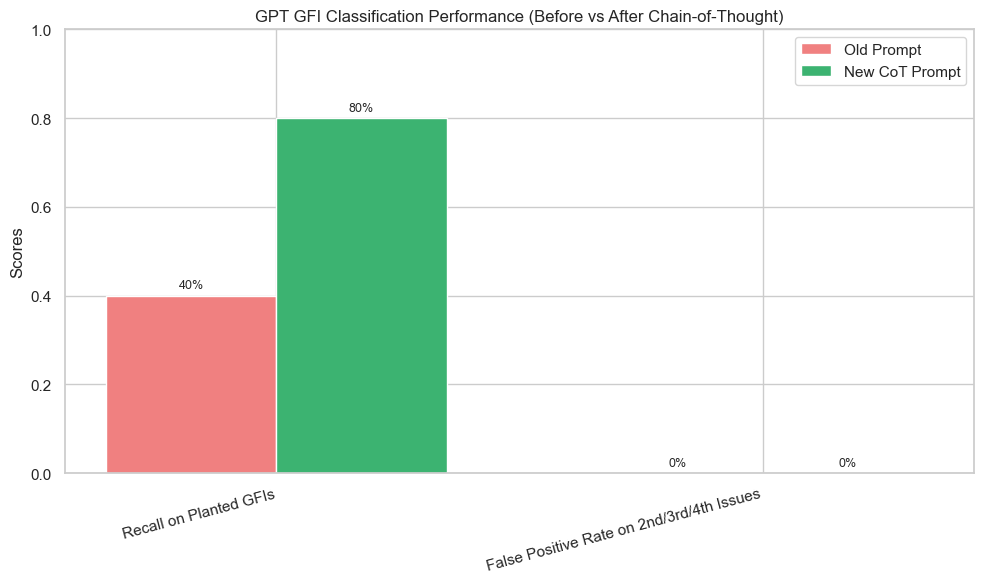

In [176]:
# Plot differences between before and after

metrics = ['Recall on Planted GFIs', 'False Positive Rate on 2nd/3rd/4th Issues']
old_values = [0.40, 0.00]  # Before Chain-of-Thought
new_values = [0.80, 0.00]  # After Chain-of-Thought

x = np.arange(len(metrics))  # label locations
width = 0.35  # bar width

# Plot
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, old_values, width, label='Old Prompt', color='lightcoral')
rects2 = ax.bar(x + width/2, new_values, width, label='New CoT Prompt', color='mediumseagreen')

# Labels and title
ax.set_ylabel('Scores')
ax.set_title('GPT GFI Classification Performance (Before vs After Chain-of-Thought)')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15, ha="right")
ax.set_ylim(0, 1.0)
ax.legend()

# Add text annotations
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0%}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_labels(rects1)
add_labels(rects2)

# Layout adjustment
plt.tight_layout()
plt.show()


Again, at this stage, we only evaluated GPT’s classification on the injected GFIs and injected non-GFIs.
We did not yet evaluate GPT on the entire dataset of unlabeled issues.

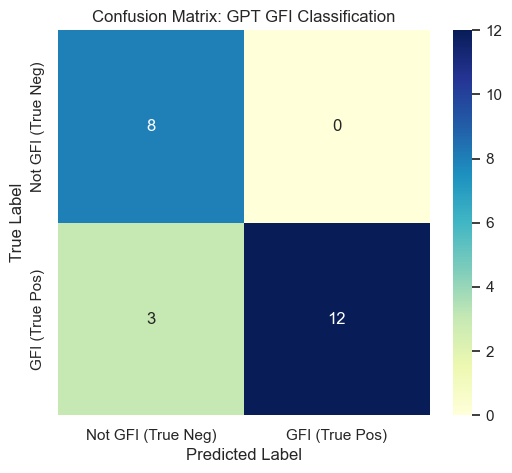

In [182]:
# Confusion Matrix

# True labels
# Planted GFIs are positives (1), Good 2/3/4 Issues are negatives (0)

true_labels = []
predicted_labels = []

for idx, row in df_full.iterrows():
    if row.get('is_planted_gfi', False):
        true_labels.append(1)  # GFI = Positive
    elif pd.notnull(row.get('original_issue_label')):  
        true_labels.append(0)  # Good Second/Third/Fourth = Negative
    else:
        continue  # Ignore other non-labeled issues

    # GPT Prediction
    gpt_predicted = str(row.get('gpt_prediction', '')).lower()
    if "good first issue: yes" in gpt_predicted:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

# Create Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Labels
labels = ['Not GFI (True Neg)', 'GFI (True Pos)']

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: GPT GFI Classification')
plt.show()


Comments:</br>

| Cell           | Meaning                                                    |
| -------------- | ---------------------------------------------------------- |
| Top-left       | True Negatives (TN) (Good 2/3/4 issues correctly rejected) |
| Top-right      | False Positives (FP) (Wrongly accepted as GFIs)            |
| Bottom-left    | False Negatives (FN) (Real GFIs wrongly rejected)          |
| Bottom-right   | True Positives (TP) (Real GFIs correctly accepted)         |

In [192]:
# Precision, recall, F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"🎯 Precision: {precision:.2%}")
print(f"🎯 Recall: {recall:.2%}")
print(f"🎯 F1-Score: {f1:.2%}")

🎯 Precision: 100.00%
🎯 Recall: 80.00%
🎯 F1-Score: 88.89%


GPT never falsely called a non-GFI a GFI (precision 100%)</br>
GPT caught 80% of the real GFIs</br>
Overall F1 balance is around 89%.

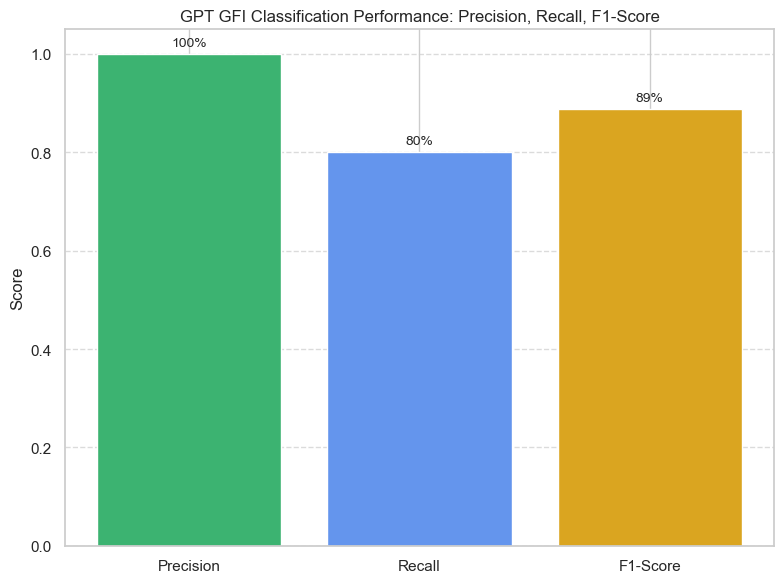

In [195]:
# Plot of precisio, recall, f1 score

metrics_names = ['Precision', 'Recall', 'F1-Score']
metrics_values = [precision, recall, f1]

# Plot
plt.figure(figsize=(8,6))
bars = plt.bar(metrics_names, metrics_values, color=['mediumseagreen', 'cornflowerblue', 'goldenrod'])

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.0%}', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('GPT GFI Classification Performance: Precision, Recall, F1-Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


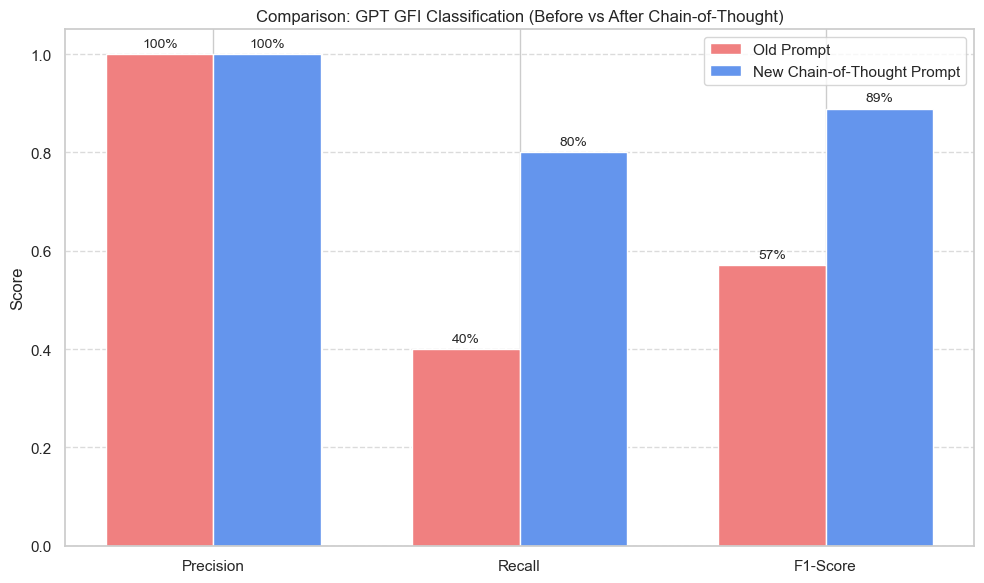

In [197]:
# Plot difference between the old results and the new ones

old_precision = 1.00  # Old system (e.g., 100%)
old_recall = 0.40     # Old system recall (40%)
old_f1 = 0.57         # Computed from old precision/recall

new_precision = precision  # From Chain-of-Thought run above
new_recall = recall
new_f1 = f1

metrics_names = ['Precision', 'Recall', 'F1-Score']

# Set up values
old_values = [old_precision, old_recall, old_f1]
new_values = [new_precision, new_recall, new_f1]

x = np.arange(len(metrics_names))  # label locations
width = 0.35  # width of bars

# Plot
fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, old_values, width, label='Old Prompt', color='lightcoral')
bars2 = ax.bar(x + width/2, new_values, width, label='New Chain-of-Thought Prompt', color='cornflowerblue')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Comparison: GPT GFI Classification (Before vs After Chain-of-Thought)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1.05)
ax.legend()

# Annotate bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0%}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
